# **@21**
# **Version 1.0**

# PreProcessing


**The following packages will be used to implement a basic GAN system in Python/Keras. Importing libraries and layers from tensorflow.**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
from keras.models import load_model

**The following code mounts Google drive for use with Google CoLab**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Setting hyperparameters for computation.Here, we mention parameters for image resolution, preview image size details,seed size,epochs,batch size and buffer size.**


In [ ]:
#resolution of images
GENERATE_SQUARE = 96 #96x96
IMAGE_CHANNELS = 3  #RGB

# Preview images for viewing samples during training
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from (noise vector)
SEED_SIZE = 100  

# Configuration
DATA_PATH = '/content/drive/My Drive/Datasets/benign_raw' #copy file location of unzipped 
EPOCHS = 2000
BATCH_SIZE = 32
BUFFER_SIZE = 600

print(f"Will generate {GENERATE_SQUARE}px square images.")

**We store the processed file as a binary. This way we can simply reload the processed training data and quickly use it. It is most efficient to only perform this operation once. The dimensions of the image are encoded into the filename of the binary file because we need to regenerate it if these change. Converting input images from the dataset to arrays. As the colored images have values of varying from (0,255) pixel values, scaling it to (-1, 1) as of generator's last layer's activation Tanh range.**

In [ ]:
#converting of (255,255) pixel value to (-1, 1) as of generator's last layer's activation Tanh range

training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')


print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  print("Loading training images...")

  training_data = []
  faces_path = DATA_PATH
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)



**We will use a TensorFlow Dataset object to actually hold the images. This allows the data to be quickly shuffled int divided into the appropriate batch sizes for training.Making batches of dataset for training the model in batches.**

In [ ]:
#making batches of data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# GAN

**Making a generator network using Sequential model to add the following layers.**

In [ ]:
#generator network
generator = keras.models.Sequential([
    keras.layers.Dense(6*6*256, input_shape=[SEED_SIZE]),
    keras.layers.Reshape([6, 6, 256]),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding="same"),
    keras.layers.ReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(32, (5,5), (2,2), padding="same"),
    keras.layers.ReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(32, (5,5), (2,2), padding="same"),
    keras.layers.ReLU(),
    keras.layers.Conv2DTranspose(3, (5,5), (2,2), padding="same", activation="tanh"),
])

**Input, output dimensions and parameters of every layer of generator**

In [ ]:
generator.summary()

**Making a discriminator network using Sequential model to add the following layers.**

In [ ]:
#discriminator network
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(32, (5,5), (2,2), padding="same", input_shape=[96, 96, 3]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

**Input,output dimensions and parameters of every layer of discriminator**

In [ ]:
discriminator.summary()

# Saving images

**OUT_PATH gives the destination to store the images that our deep-convolutional gan network will generate.**

In [ ]:
mkdir '/content/drive/My Drive/Datasets/21/Final_Data_22' 

In [ ]:
OUT_PATH='/content/drive/My Drive/Datasets/21/Final_Data_22' 

**As we progress through training images will be produced to show the progress.These images will contain a number of rendered dates that show how good the generator has become.Below cell has a function to save coloured images generated by dcgan in 7x4 grid to preview the images.** 

In [ ]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(OUT_PATH,f"output-{cnt}")
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)
  generator.save(os.path.join(output_path,f"face_generator-{cnt}.h5"))

# Testing networks

**Before training the model, generate random sample by adding noise in generator network and specifying training as false.**

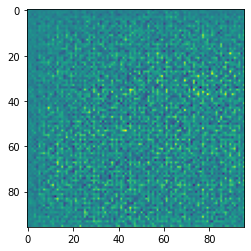

In [ ]:
#generating random sample before training
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

**Checking discriminator's decision on the random sample generated.**

In [ ]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.4998912]], shape=(1, 1), dtype=float32)


# Compiling Gan

**For the generator training set, the $x$ contains the random seeds to generate images and the $y$ always contains the value of 1, because the optimal is for the generator to have generated such good images that the discriminiator was fooled into assigning them a probability near 1.Defining loss for generator and discriminator networks. Binary crossentropy loss has been used. For the generator network the loss is only determined by the fake output that it generates.For discriminator network,total loss is the sum of loss for real and fake outputs.**

In [ ]:
#defining losses
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

**In this cell optimizer for the generator and discriminator networks have been defined. Adam optimizer(with a learning rate of 1.5e-4) is used for both the networks.**

In [ ]:
#defining otptimizer
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

# Training the Gan


**Defining a fuction for train the dcgan. We train the model by giving randomly generated seed values to the generator. The generator gives an output image, this image along with real image is feeded to the discriminator network. Gradients are calculated for both these network in the basis of generator loss and discriminator loss. Later, optimization is done using these gradients.**

In [ ]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)#calculating gradients of generator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)#calculating gradients of discriminator

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))#applying gradients with the optimizer
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))#applying gradients with the optimizer
  return gen_loss,disc_loss

In [ ]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))

  for epoch in tqdm(range(epochs)):


    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)


    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}')
    if epoch%100==0:
      save_images(epoch,fixed_seed)


 # print (f'Training time: {hms_string(epoch_elapsed)}')

**Calling the train fuction to start train the gan model for desired number of epochs.**

In [ ]:
train(train_dataset, EPOCHS)

# Generating images

**In this section 500 generated images are saved.**


In [ ]:
from keras.models import load_model

**Load the best model to generate images of dates**

In [ ]:
!mkdir '/content/drive/My Drive/Datasets/21/Final_Model/output'   

mkdir: cannot create directory ‘/content/drive/My Drive/Datasets/21/Final_Model/output’: No such file or directory


In [ ]:
#loading best model
generator = keras.models.load_model('/content/drive/My Drive/Datasets/21/final_model.h5')

**Check generator's working by plotting a generated image**

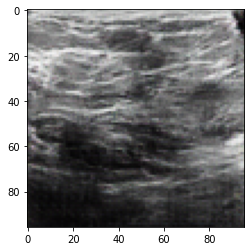

In [ ]:
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)
generated_image = 0.5 * generated_image + 0.5
plt.imshow(generated_image[0, :, :, :])

In [ ]:
import numpy as np


**Define the directory where results folder will be made**

In [ ]:
OUT_PATH_samples='/content/drive/My Drive/Datasets/21'

In [ ]:
output_samples_path = os.path.join(OUT_PATH_samples,f"results")

**Make results folder in OUT_PATH_SAMPLES**

In [ ]:
!mkdir '/content/drive/My Drive/Datasets/21/results'

**Below cell saves 500 synthetically generated images to the output_samples_path.**

In [ ]:
x=500 # no of samples to be generated
for i in range(x):
  noise = tf.random.normal([1, SEED_SIZE])
  generated_image = generator(noise, training=False)
  generated_image = 0.5 * generated_image + 0.5
  generated_image=generated_image[0, :, :, :]
  filename = os.path.join(output_samples_path,f"aloa-{i}.png")
  generated_image=np.asarray(generated_image)
  im = Image.fromarray((generated_image * 255).astype(np.uint8))
  im.save(filename)
